# Cifar10 上的 ReNet18

本文主要介绍如何对 Sigmoid 进行线性化，且在 cifar10 的试验 resnet18 的性能。

导入一些必要包：

In [1]:
import torch
from torch import nn, fx, optim
from torch.nn import functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.data.simple_vision import load_data_cifar10
from torch_book.tools import train, try_all_gpus #try_gpu

torch.cuda.empty_cache() # 清空 GPU 缓存

def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                            model.conv1.out_channels, 
                            3, 1, 1)
    model.maxpool = nn.Identity() #nn.Conv2d(64, 64, 1, 1, 1)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

torchvision 上的 ResNet18 直接用于 cifar10 是不推荐的。需要做以下改动：

In [2]:
batch_size = 64
train_iter, test_iter = load_data_cifar10(batch_size=batch_size)
model = create_model()

Files already downloaded and verified
Files already downloaded and verified


```{note}
将第一个 conv 替换以支持 $32 \times 32$ 的输入。同时移除第一个 `maxpool` 避免图片信息过早丢失。
```

查看修改后的模型：

In [3]:
model.conv1

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [4]:
model.maxpool

Identity()

打印每层输出尺寸：

In [5]:
for xs, _ in train_iter:
    break

for name, m in model.named_children():
    xs = m(xs)
    print(name, tuple(xs.shape))
    if name=="avgpool":
        xs = torch.flatten(xs, 1)

conv1 (64, 64, 32, 32)
bn1 (64, 64, 32, 32)
relu (64, 64, 32, 32)
maxpool (64, 64, 32, 32)
layer1 (64, 64, 32, 32)
layer2 (64, 128, 16, 16)
layer3 (64, 256, 8, 8)
layer4 (64, 512, 4, 4)
avgpool (64, 512, 1, 1)
fc (64, 10)


微调模型：

In [12]:
def fine_tune(mod, num_epochs,
              train_iter, test_iter,
              devices=try_all_gpus(),
              lr=0.0000142857,
              lr_period=4,
              lr_decay=0.0857142,
              weight_decay=0.00857142,
              momentum=0.857142):
    optimizer = optim.SGD(mod.parameters(),
                          lr=lr,
                          momentum=momentum, 
                          weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                          step_size=lr_period, 
                                          gamma=lr_decay)
    train(mod, train_iter, test_iter,
          num_epochs, devices,
          optimizer, scheduler)
    return mod

train loss 0.015, train acc 0.996, valid acc 0.920
1579.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


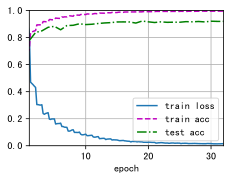

In [7]:
model = create_model()
mod = fine_tune(model, 32,
                train_iter, test_iter, 
                try_all_gpus(),
                lr=0.000142857,
                lr_period=2,
                lr_decay=0.857142,
                weight_decay=0.00857142,
                momentum=0.857142)

torch.save(mod.state_dict(), 
           'models/resnet18_cifar10_batch_size_64.h5')

In [11]:
batch_size = 32
train_iter, test_iter = load_data_cifar10(batch_size=batch_size)
model = create_model()
mod = fine_tune(model, 32,
                train_iter, test_iter, 
                try_all_gpus(),
                lr=0.000142857,
                lr_period=2,
                lr_decay=0.857142,
                weight_decay=0.00857142,
                momentum=0.857142)

torch.save(mod.state_dict(), 
           f'models/resnet18_cifar10_batch_size_{batch_size}.h5')

In [8]:
# 性能度量
# inputs = torch.randn(5, 3, 32, 32)
# with profile(activities=[ProfilerActivity.CPU],
#              record_shapes=True) as prof:
#     with record_function("model_inference"):
#         model(inputs)
# print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", 
#                                                          row_limit=10))
# model = model.cuda()
# inputs = torch.randn(5, 3, 32, 32).cuda()

# with profile(activities=[
#         ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("model_inference"):
#         model(inputs)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

## 模块变换

利用 FX 替换全部 {class}`~torch.nn.ReLU` 为 {func}`torch.sigmoid`。

In [9]:
def replace(model):
    mod = fx.symbolic_trace(model)
    # 遍历 Graph 中全部节点
    for node in mod.graph.nodes:
        # 如果匹配目标
        if node.op == "call_module":
            if "relu" in node.target:
                # 设置插入点，添加新节点，用新节点替换所有 `node` 的用法
                with mod.graph.inserting_after(node):
                    new_node = mod.graph.call_function(torch.sigmoid, node.args, node.kwargs)
                    node.replace_all_uses_with(new_node)
                # 移除 graph 中旧的节点
                mod.graph.erase_node(node)
    mod.graph.lint()
    # 不用忘记 recompile！
    new_code = mod.recompile()
    return mod